# Buzzer control analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
analysis_type = 'buzzer'  # Analysis type
mouseline = 'sst' # Mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = np.median   # trial aggregation function
ykey_classification = Label.ZSCORE  # variable of interest for classification
directional = True  # whether to look for directional (i.e. positive only) effect for response detection

### Derived parameters

In [4]:
# Get batch-related settings
dataset_group_id, trialavg_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'

# Derive output metrics of interest
outkey = get_change_key(ykey_classification)

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} batch notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 19/01/2023 14:48:47: assembling batch analysis settings...
 19/01/2023 14:48:47: sst batch notebook started on 2023-01-19 at 14:48:47


### Input summary table figure

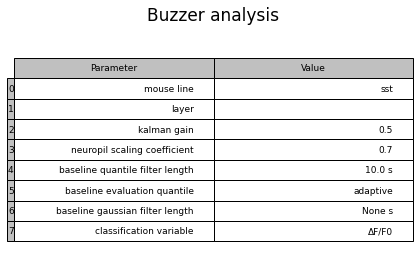

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'classification variable': ykey_classification
    }, title='Buzzer analysis', aspect=1.5)

## Input data

### Load data

In [6]:
# Determine exclude patterns
exclude_patterns = {
    'line3': [
    ],
    'sst': [
        '20190602_mouse7_region2',   # TO DOCUMENT
    ]
}[mouseline]

# Determine what to do in case of duplicate runs
on_duplicate_runs = 'pass'

# Load datasets
logger.info(f'loading data from {trialavg_dir}:')
data = load_trialavg_datasets(
    trialavg_dir, layer=layer, include_mode='any',
    exclude_patterns=exclude_patterns,
    on_duplicate_runs=on_duplicate_runs,
    harmonize_runs=False, 
    condition='buzzer')

 19/01/2023 14:48:47: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/aggmedian_classΔFF0/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/buzzer/sst:
 19/01/2023 14:48:47: excluding datasets with the following patterns:
 - 20190602_mouse7_region2
 19/01/2023 14:48:47: loading trial-averaged data from 20190602_mouse2_region2.h5
 19/01/2023 14:48:48: loading trial-averaged data from 20190602_mouse2_region3.h5
 19/01/2023 14:48:48: loading trial-averaged data from 20190602_mouse7_region1.h5
 19/01/2023 14:48:48: loading trial-averaged data from 20190605_mouse2_region1.h5
 19/01/2023 14:48:48: loading trial-averaged data from 20190605_mouse7_region1.h5
 19/01/2023 14:48:48: loading trial-averaged data from 20190719_mouse2_region1.h5
 19/01/2023 14:48:48: loading trial-averaged data from 20190719_mouse6_region1.h5
 19/01/2023 14:48:48: gathering dataset IDs...
 19/01/2023 14:48:48: sorting dataset indexes...
 19

### Filter out datasets, classify cells and show breakdown & map per dataset

 19/01/2023 14:48:48: extracting timeseries and stats from data...
 19/01/2023 14:48:48: excluding datasets with missing conditions...
 19/01/2023 14:48:48: cell breakdown:
  - positive: 953 (85.3%)
  - weak: 164 (14.7%)
 19/01/2023 14:48:48: plotting cell maps...


5it [00:03,  1.43it/s]                       


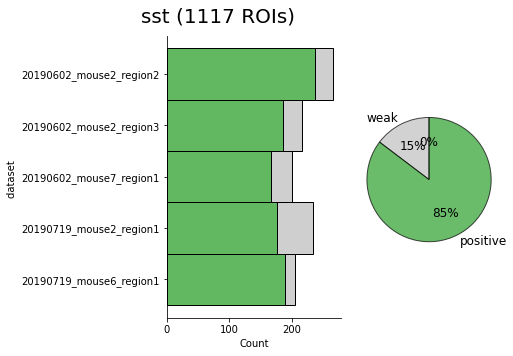

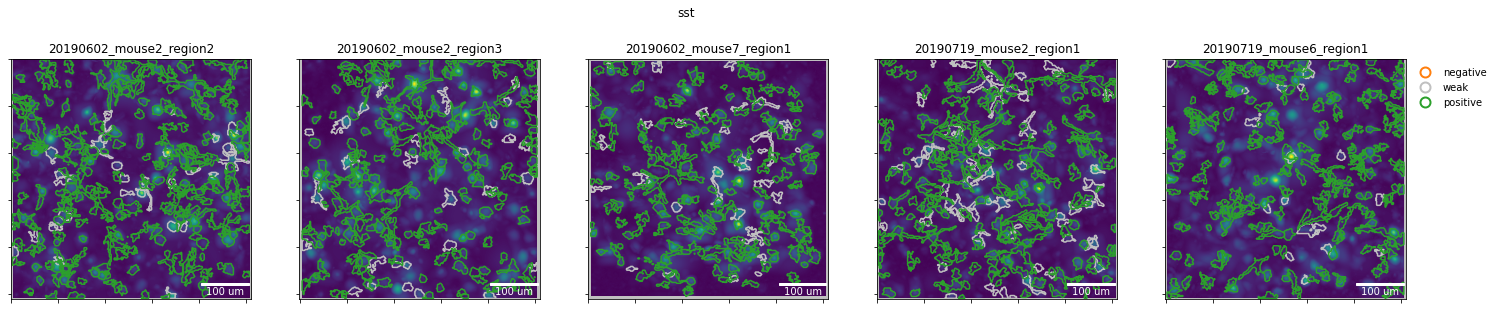

In [7]:
# Extract fields from data
timeseries, stats, ROI_masks, map_ops = extract_from_batch_data(data)

# Create conditions column with better names
ckey = 'condition'
condkeys_map = {
    'sound': 'sound',
    'tus': 'US',
    'sound_tus': 'sound+US'
}
stats[ckey] = stats[Label.SUFFIX].map(condkeys_map)

# Exclude datasets with missing conditions
logger.info('excluding datasets with missing conditions...')
ncondsperdataset = stats[ckey].groupby(Label.DATASET).nunique()
valid_datasets = ncondsperdataset[ncondsperdataset == 3].index
timeseries = timeseries.loc[pd.IndexSlice[valid_datasets]]
stats = stats.loc[pd.IndexSlice[valid_datasets]]
ROI_masks = ROI_masks.loc[pd.IndexSlice[valid_datasets]]
map_ops = {k: map_ops[k] for k in valid_datasets}

# Compute number of occurences per response type per ROI
roistats = stats[Label.RESP_TYPE].groupby(
    [Label.DATASET, Label.ROI]).value_counts().unstack().replace(np.nan, 0.).astype(int)

# Classify ROIs based on number of responsive conditions
roistats[Label.ROI_RESP_TYPE] = 'weak'
roistats.loc[roistats['positive'] >= 1, Label.ROI_RESP_TYPE] = 'positive'

# Log number and percentage of cells of each type identified
ncells_per_type = roistats[Label.ROI_RESP_TYPE].value_counts()
ncells_tot = ncells_per_type.sum()
logstr = []
for rtype, count in ncells_per_type.iteritems():
    logstr.append(f'  - {rtype}: {count} ({count / ncells_tot * 100:.1f}%)')
logstr = "\n".join(logstr)
logger.info(f'cell breakdown:\n{logstr}')

# Add roistats to stats
stats = expand_and_add(roistats, stats.copy())

# Plot cell count breakdown
figs['rtype dist per mousereg'] = plot_cellcounts(stats, title=mouseline)
# Plot cell maps
figs['cellmaps'] = plot_cell_maps(
    ROI_masks, stats, map_ops, title=mouseline, refkey='Vcorr', mode='contour')

# # Restrict analysis to positive responders
# logger.info('restricting dataset to positive responders only...')
# mux_pos = stats[stats[Label.ROI_RESP_TYPE] == 'positive'].index.droplevel(-1).unique()
# idx_pos = pd.IndexSlice[mux_pos.get_level_values(0), mux_pos.get_level_values(1)]
# stats = stats.loc[idx_pos, :]
# timeseries = timeseries.loc[idx_pos, :]

### Plot responders traces vs condition

 19/01/2023 14:48:53: assembling plot data...
 19/01/2023 14:48:53: adding time info to table...
 19/01/2023 14:48:53: plotting responders traces across conditions & datasets...
 19/01/2023 14:48:55: plotting aggregate responders traces across conditions...


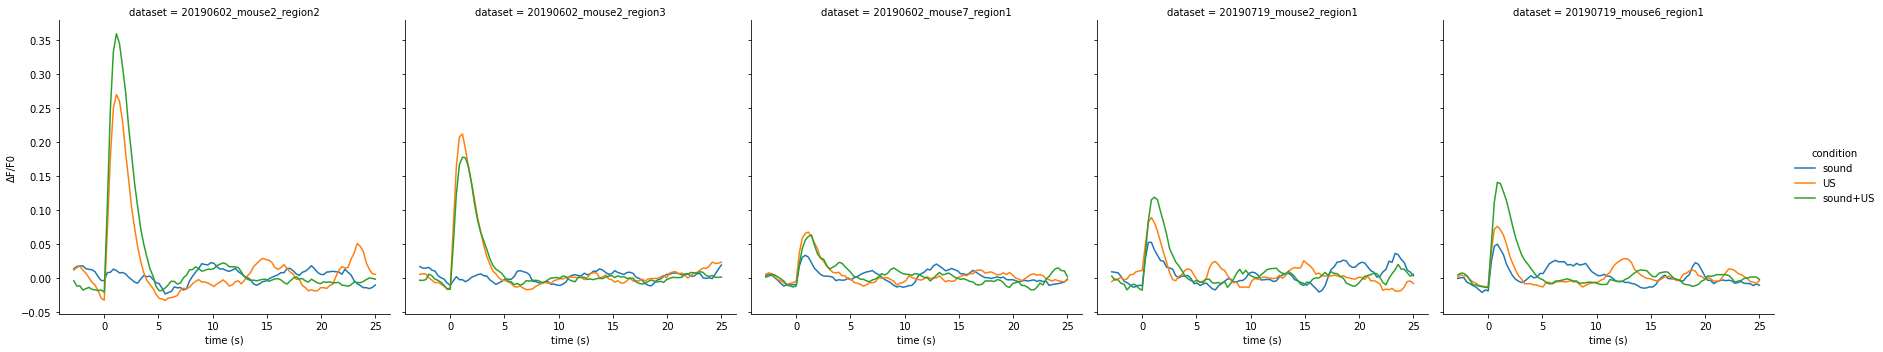

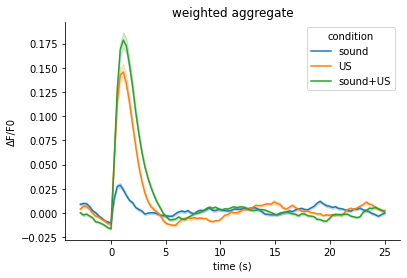

In [8]:
# Get plot data
logger.info('assembling plot data...')
pltdata = expand_and_add(stats[ckey], timeseries.copy())
# Add time
fps = get_singleton(stats, Label.FPS)
pltdata = add_time_to_table(pltdata, fps=fps)

# Plot parameters
palette = None
ci = None

# Plot response traces vs. offset for each dataset
logger.info('plotting responders traces across conditions & datasets...')
fg = sns.relplot(
    data=pltdata, x=Label.TIME, y=Label.DFF, kind='line',
    hue=ckey, col=Label.DATASET, ci=ci, hue_order=condkeys_map.values())
figs['traces_vs_offset_per_dataset'] = fg.figure

# Plot weighted aggregate response traces vs. offset
logger.info('plotting aggregate responders traces across conditions...')
figs['traces_vs_offset_agg'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('weighted aggregate')
sns.lineplot(
    data=pltdata, x=Label.TIME, y=Label.DFF, ax=ax,
    hue=ckey, ci=CI, hue_order=condkeys_map.values());

### Plot response strength per condition

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

US vs. sound: t-test paired samples, P_val:4.626e-02 t=2.853e+00
sound vs. sound+US: t-test paired samples, P_val:1.218e-03 t=-8.177e+00
US vs. sound+US: t-test paired samples, P_val:1.192e-01 t=-1.977e+00


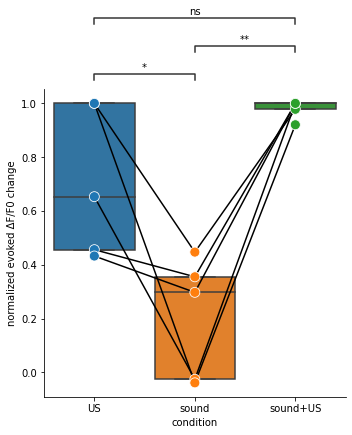

In [9]:
# Compute normalized response strength for each dataset
maxperdataset = stats.groupby([Label.DATASET, ckey])[outkey].mean().groupby(Label.DATASET).max()
normkey = f'normalized {outkey}'
stats[normkey] = stats[outkey] / maxperdataset

# Plot response strength per condition
# figs['paired_comps_across_datasets'] = plot_comparative_metrics_across_datasets(
#     stats.copy(), normkey, ckey, 
#     kind='box', notch=True, showfliers=False)
figs['paired_comps'] = plot_comparative_metrics_across_conditions(
    stats, normkey, ckey, paired=True)

### Save figures

In [10]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 19/01/2023 14:49:05: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2023.01.19/figs_buzzer_sst_k0.5_alpha0.7_qadaptive_wq10.0s_aggmedian_classΔFF0.pdf:


100%|██████████| 6/6 [00:01<00:00,  4.56it/s]


### Notify upon completion

In [11]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 19/01/2023 14:49:06: sst batch notebook completed in 0:00:19.266918 s
